# PCA and cluster quality analysis

In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

## A 'single cell seq' type dataset

We are going to skip a bunch of biology and wet lab realities and generate a toy dataset with many characteristics of a real single cell sequencing experiment. In these types of experiments, RNA is extracted from many individual cells and the number of copies (also known as number of "reads") of RNA molecules for particular genes is quantified. Here we generate a dataset in which we quantify the number of reads for 200 genes from many cells which belong to some number of cell types. Typically in such a 'single cell seq' dataset, the exact number of cell types are not known in advance nor is the the correspondence between cells and cell types. Typically we need to figure this out through data analysis. We are going to use PCA and clustering to perform these jobs.

<IPython.core.display.Javascript object>


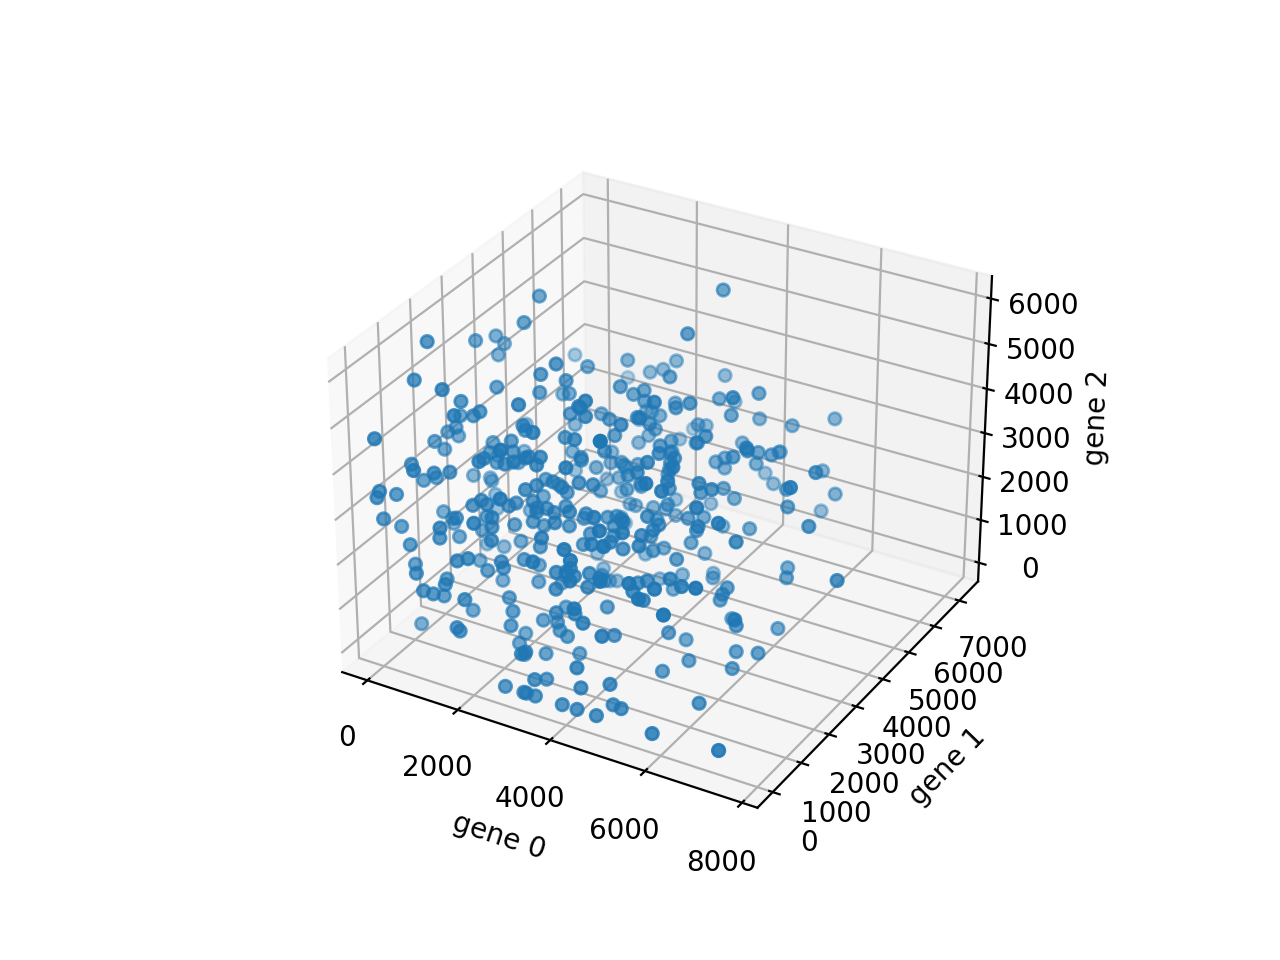

In [2]:
# Generate some fake data with known characteristics.
#
# NOTE: Don't read this code upon first run-through of the notebook. This
# would spoil the rest of the work we do below to "discover" what was done
# here in the data generation step.

n_samples_per_cluster = 100
n_dim = 200
n_clusters = 4

def gen_covar_mat(ndim):
    result = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(i,ndim):
            value = np.random.randn(1,1)[0]
            result[i,j] = value
            result[j,i] = value
    return result

np.random.seed(1)

X_train = []
for i in range(n_clusters):

    center = 10*np.random.randn(n_dim) + np.array([10]*n_dim)
    
    C = gen_covar_mat(n_dim)
    stretched_gaussian = np.dot(np.random.randn(n_samples_per_cluster, n_dim), C) + center

    big_positive = (100*stretched_gaussian + np.array([1000]*n_dim))
    
    big_positive = np.clip(big_positive,0, np.inf)
    big_positive = np.round(big_positive)    
    X_train.append( big_positive )


# concatenate the datasets into the final training set
X_train = np.vstack(X_train)

# shuffle the rows
idxs = np.arange(len(X_train))
idxs = np.random.shuffle(idxs)
X_train = X_train[idxs][0]

x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# plt.figure()
# plt.scatter(X_train[:, 0], X_train[:, 1], .8)
# plt.xlabel("num reads (gene 0)")
# plt.ylabel("num reads (gene 1)");

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], '.')
ax.set_xlabel('gene 0')
ax.set_ylabel('gene 1')
ax.set_zlabel('gene 2');

In [3]:
import pandas as pd

data = {}
for i in range(n_dim):
    name = 'gene %d'%i
    data[name] = X_train[:,i].astype(np.int64)

df = pd.DataFrame(data=data)


Now let's have a first look at this data.

In [4]:
df

,gene 0,gene 1,gene 2,gene 3,gene 4,gene 5,gene 6,gene 7,gene 8,gene 9,...,gene 190,gene 191,gene 192,gene 193,gene 194,gene 195,gene 196,gene 197,gene 198,gene 199
0,6329,2843,211,1152,3990,0,5046,1014,2576,554,...,2261,2760,6334,4104,3510,194,2165,544,2967,4166
1,4196,2854,2430,0,6139,1301,4882,1231,393,1589,...,3136,414,4671,2862,3311,0,4260,3011,3655,2244
2,0,1083,3509,0,1371,0,2117,2769,3874,790,...,2525,1306,3889,3890,2942,0,1147,1706,2621,2170
3,5216,215,2992,729,2003,348,1528,0,1487,696,...,4419,620,4851,4084,4514,0,233,3176,1183,2661
4,1370,95,1812,172,3696,3285,4202,1321,4099,1066,...,2787,566,4824,4440,4346,0,2130,1498,2840,3426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1120,2184,3273,4078,1391,4020,926,1008,0,2771,...,1411,2680,3576,1719,3002,3094,2685,0,1499,3172
396,200,2231,3760,2140,639,2361,2165,1072,659,2392,...,3884,3814,4327,1997,71,1551,4396,954,3456,2964
397,2819,1761,3465,5406,2306,5221,3042,586,465,2791,...,366,2801,4754,4591,0,0,1058,1972,2719,1035
398,733,2635,3357,5571,567,4203,2995,256,974,5646,...,1461,2347,1631,3641,160,0,0,1409,4058,835


# first impressions of the data

So, how does our data look? At first glance it looks... like a bunch of random numbers with no real structure! But could there be some structure? For example, above we learned that although many cells have been sequenced, we expect these are from only a very limited number of cell types.

How can we figure out something about these cell types?

Let's make use of principal component analysis (PCA) and clustering from scikit-learn as some of the first tools in our toolkit.

## Converting to plain numpy

While Pandas is very convenient for many things, scikit learn uses plain numpy arrays and generally works best when the datatype is a floating point number rather than an integer. Let's do this conversion now and call our data `X`.

We need to make a copy of this so that it is "C contiguous" (this is the default numpy layout of the data but when creating a view of other data, the internal layout can be different).

In [5]:
X = df.to_numpy(dtype=np.float64).copy()

## PCA

Let's first run PCA on our data.

In [6]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)

The results of our analysis are stored in the variable `pca`. We can use this to project our original high dimensional data into its principle components and plot just the first dimensions in this "principle component space".

In [7]:
projected = pca.transform(X)

<IPython.core.display.Javascript object>


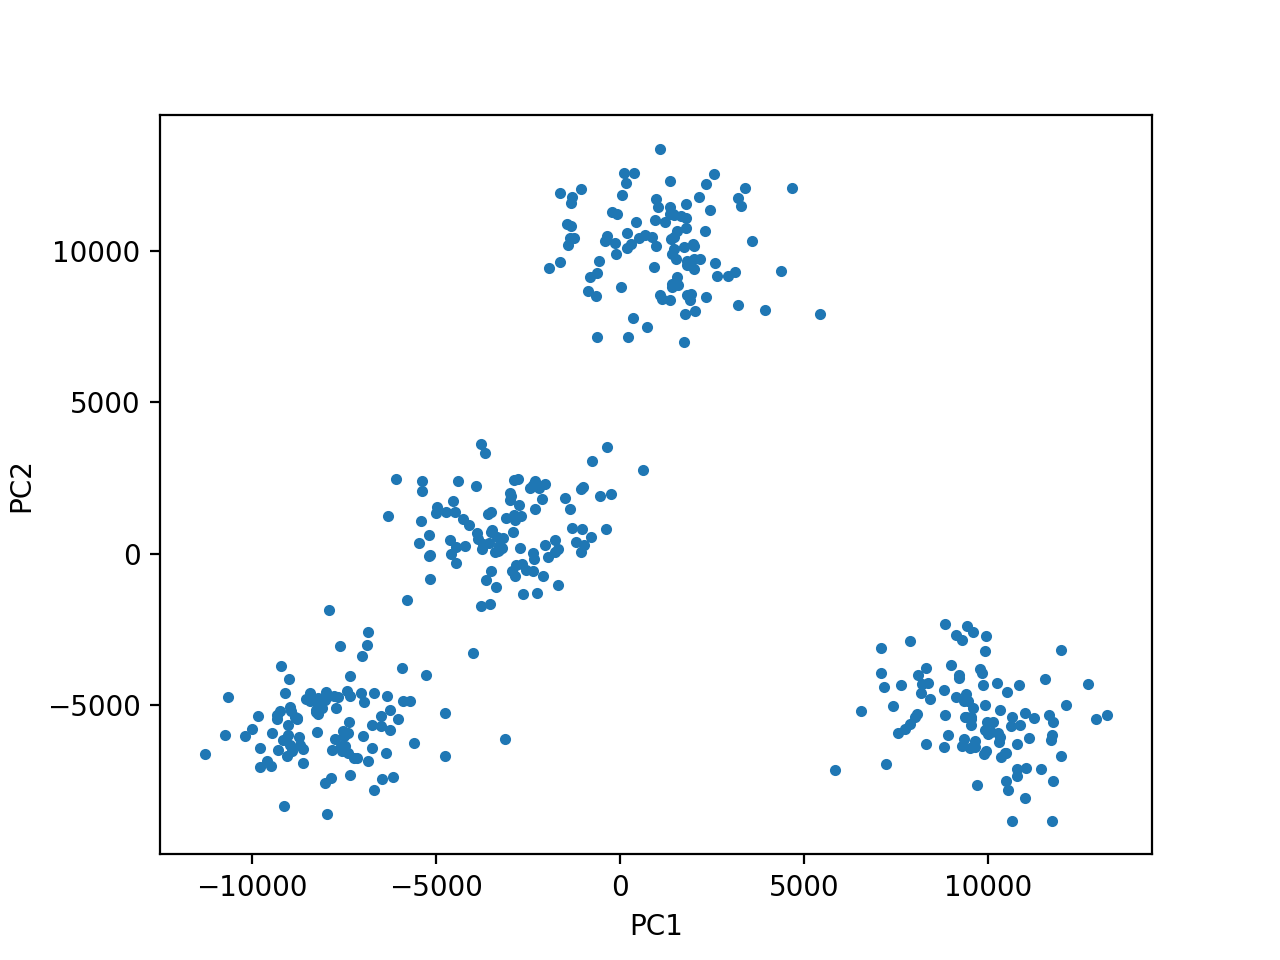

In [8]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(projected[:,0], projected[:,1], '.')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

<IPython.core.display.Javascript object>


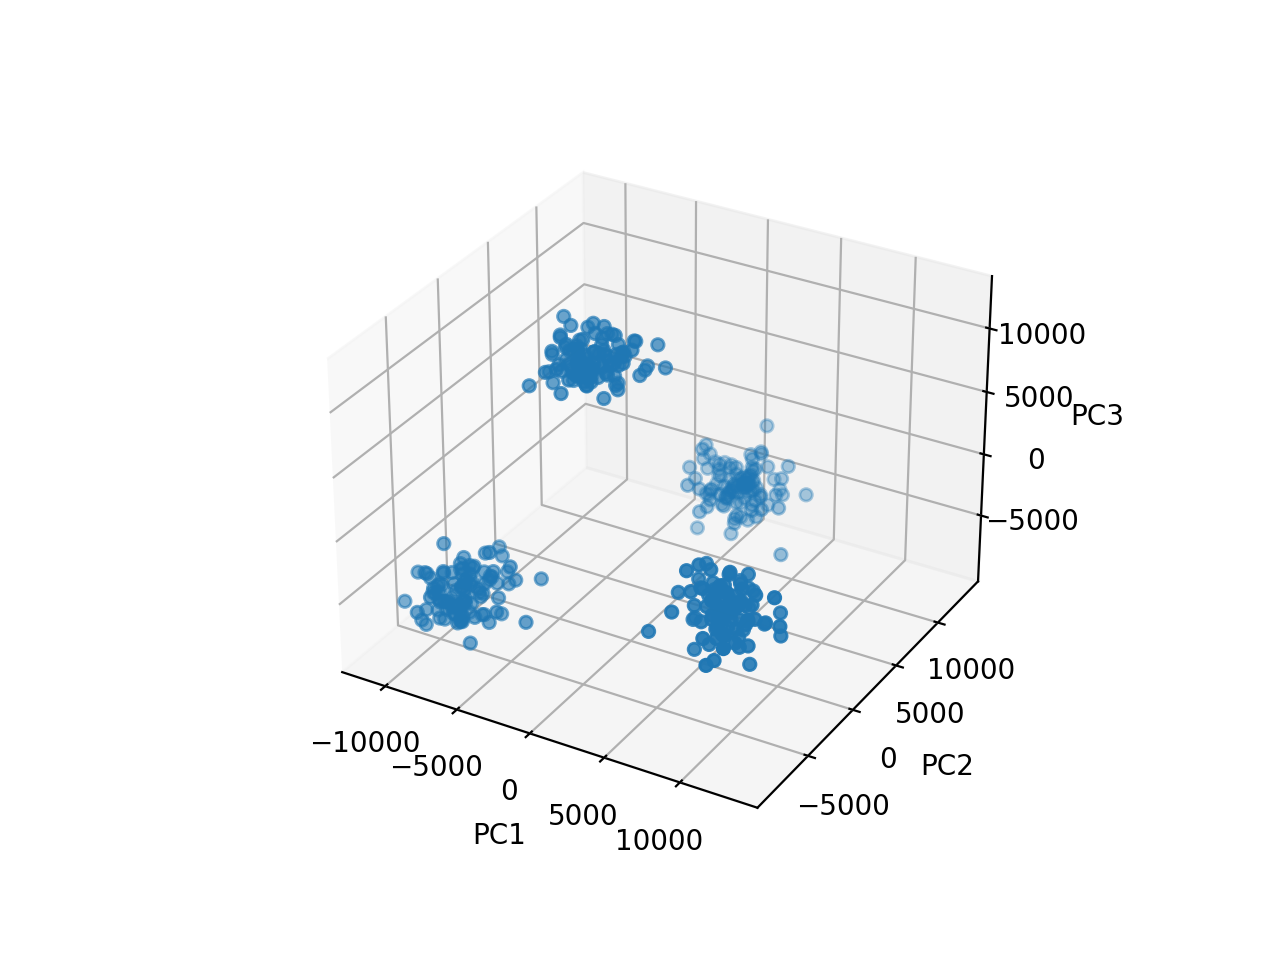

In [9]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected[:,0], projected[:,1], projected[:,2], '.')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3');

## Structure in the PCA space

Now, what do you notice about the data in this PCA space?

Now, instead of looking like a structure-free blob, we seem to have some structure. What kind of structure do we have?

"N clusters", I hope you are thinking. Biologically speaking, we are now guessing that there were this many cell types in our original sample.

## PCA explained variance

One of the first questions about PCA is how much of the variance in our data are "explained" by the first N components of the projected data. Let's plot this.

<IPython.core.display.Javascript object>


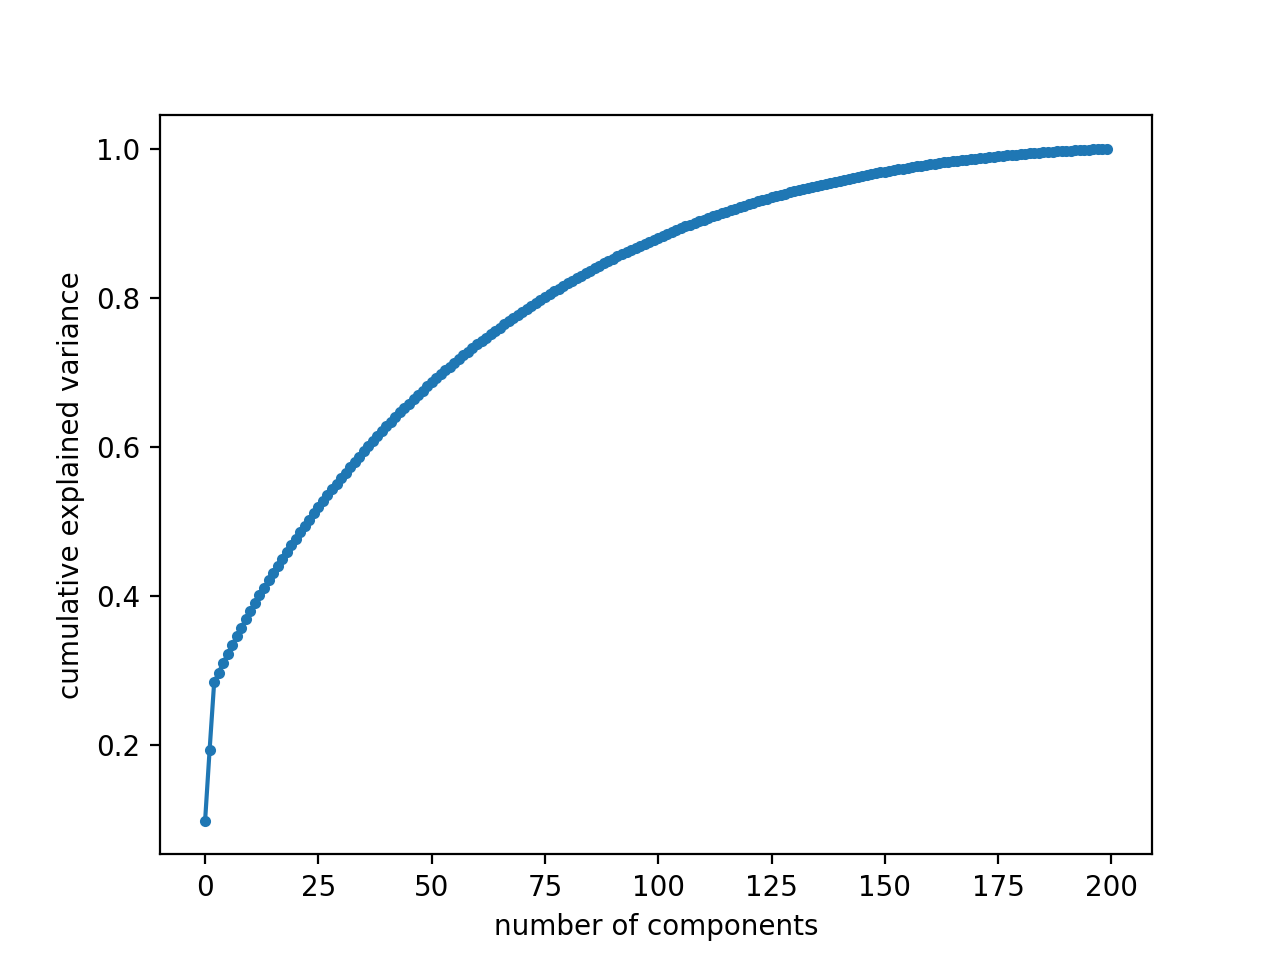

In [10]:
plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## mini batch K-Means

Given that it looks like our data may have some clusters, let's try find these clusters using mini batch K-Means.

In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [12]:
mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=6, random_state=0).fit(X);

## plotting the clustering results in the original "number of reads" space

Let's first plot the our raw read data in a scatter plot like above, but colored according to our cluster label. We will also plot our cluster centers here.

In [13]:
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

<IPython.core.display.Javascript object>


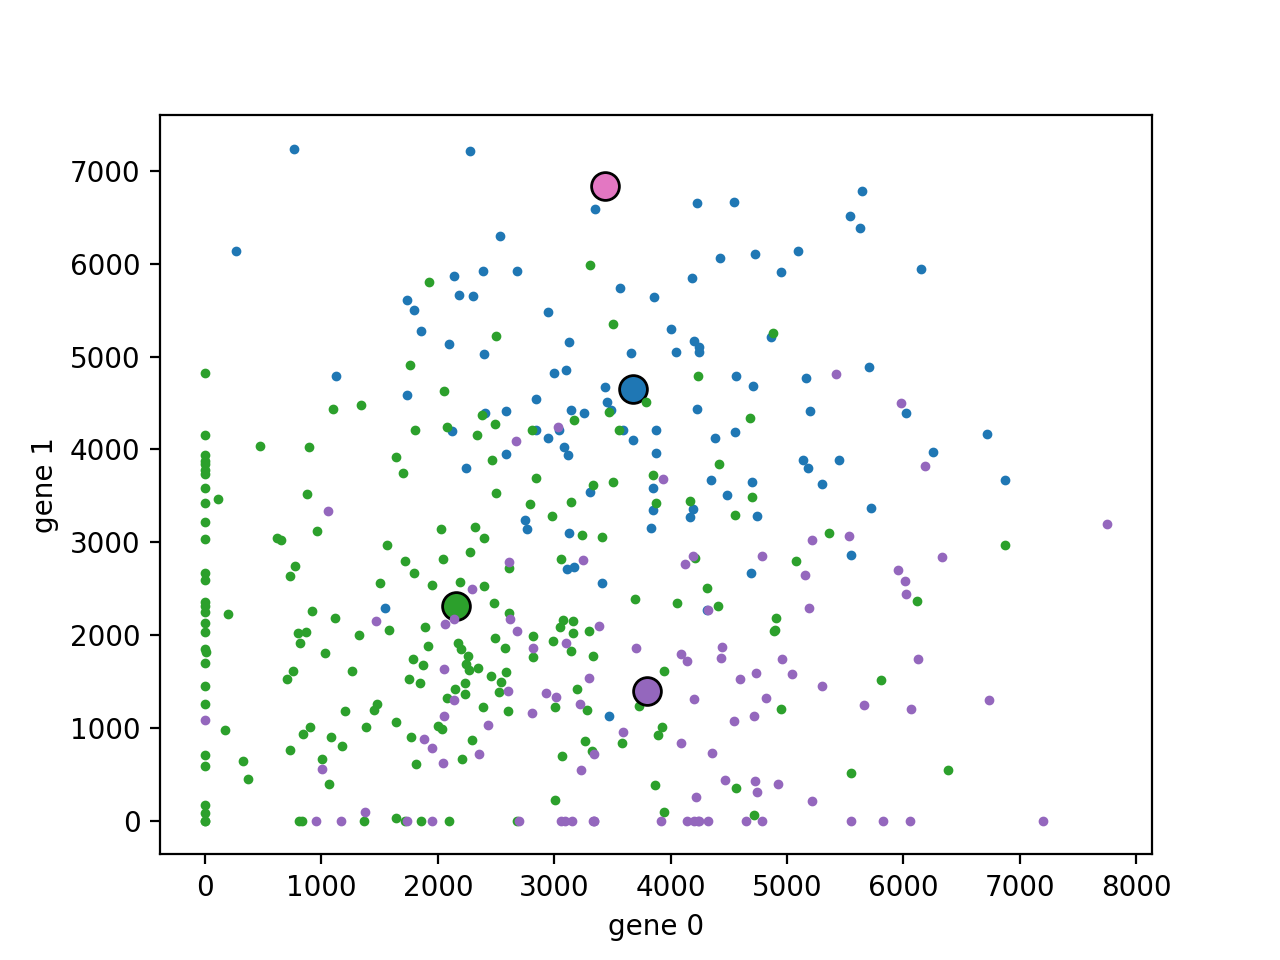

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)

x_gene_idx = 0
y_gene_idx = 1

for k in range(n_clusters):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    line, = ax.plot(X[my_members, x_gene_idx], X[my_members, 1], '.', markersize=5)
    ax.plot(cluster_center[x_gene_idx], cluster_center[1], 'o', markersize=10, markeredgecolor='black', markerfacecolor=line.get_color())
ax.set_xlabel('gene %d' % x_gene_idx)
ax.set_ylabel('gene %d' % y_gene_idx);

## plotting the clustering results in PCA space

Hmm, the plot above was not too informative. It does not seem to show obvious clusters in the data, and the points look very interwoven with others, at least for these two genes.

Let's re-plot our cluster assignments, but this time using the projection into PCA space.

<IPython.core.display.Javascript object>


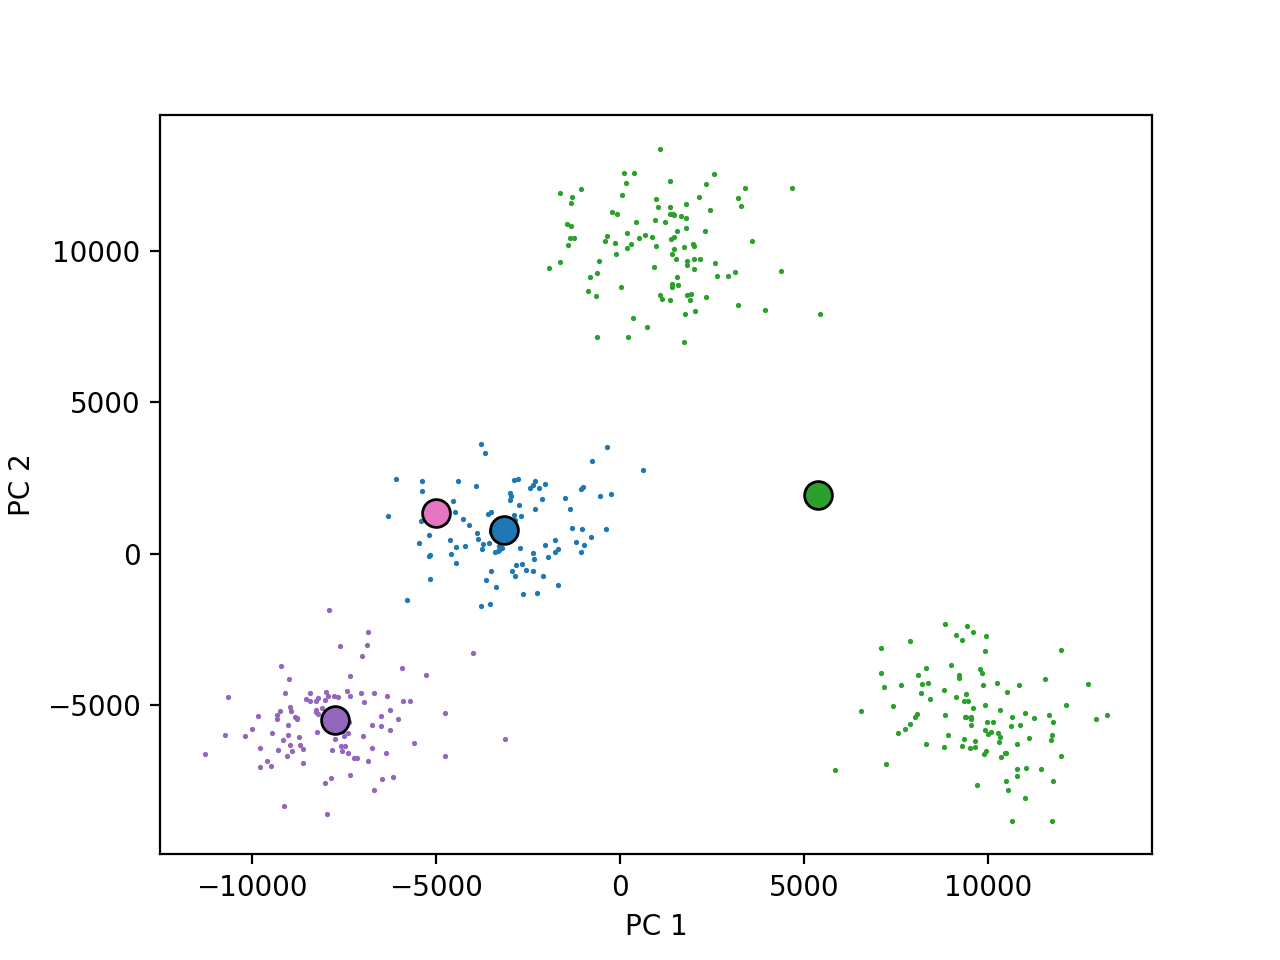

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)

projected_centers = pca.transform(mbk.cluster_centers_)

for k in range(n_clusters):
    my_members = mbk_means_labels == k
    projected_cluster_center = projected_centers[k]
    line, = ax.plot(projected[my_members, 0], projected[my_members, 1], '.',
                    markersize=1.8)
    ax.plot(projected_cluster_center[0], projected_cluster_center[1], 'o',
            markersize=10, markeredgecolor='black', markerfacecolor=line.get_color())
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2');

## silhouette analysis with K-means

OK, so that last plot (in PCA space) is looking better. The automatically detected clusters seem to agree with the idea we had from just looking at the data. Let's now use a silhouette analysis as one way to check whether this was a particularly good number of clusters for this data.


## Selecting the number of clusters with silhouette analysis on KMeans clustering

(This section modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html )

Silhouette analysis can be used to study the separation distance between the
resulting clusters. The silhouette plot displays a measure of how close each
point in one cluster is to points in the neighboring clusters and thus provides
a way to assess parameters like number of clusters visually. This measure has a
range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate
that the sample is far away from the neighboring clusters. A value of 0
indicates that the sample is on or very close to the decision boundary between
two neighboring clusters and negative values indicate that those samples might
have been assigned to the wrong cluster.

In this example, the silhouette analysis is used to inform us about an optimal value for
the best number of clusters.

Also from the thickness of the silhouette plot the cluster size can be
visualized.

In [16]:
from sklearn import cluster
from scipy.spatial import distance
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# from https://stats.stackexchange.com/a/251169/24333
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    # Note: our implementation of BIC has an inverted sign compared to that in the
    # e.g. wikipedia article, and thus the best fit has the highest value.
    
    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [18]:
# For the plots below, we need to turn off the interactive Jupyter matplotlib notebook mode.
%matplotlib inline

For n_clusters = 2 The average silhouette_score is : 0.09166163235064052
For n_clusters = 3 The average silhouette_score is : 0.12903266476088046
For n_clusters = 4 The average silhouette_score is : 0.16714540077634665
For n_clusters = 5 The average silhouette_score is : 0.13098533664401762
For n_clusters = 6 The average silhouette_score is : 0.09132872300357638


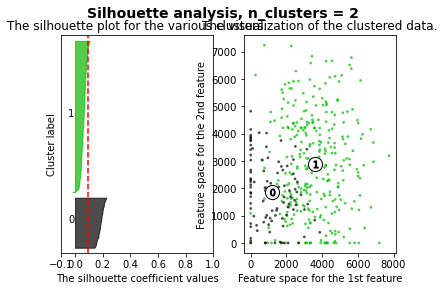

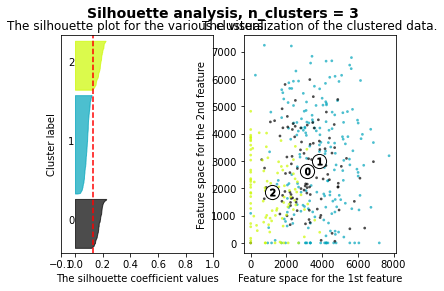

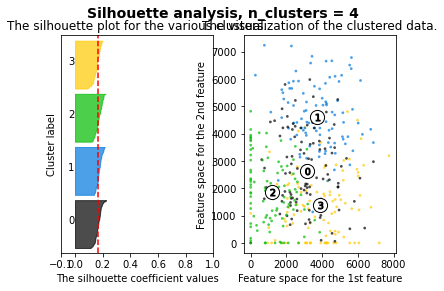

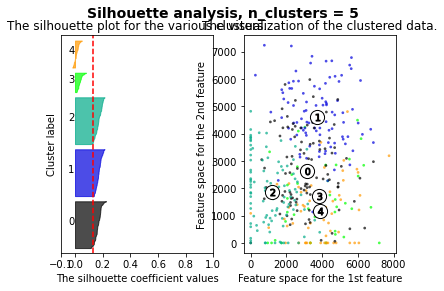

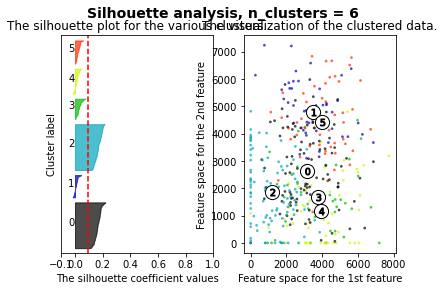

In [19]:
# Modified from https://scikit-learn.org/0.21/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
range_n_clusters = [2, 3, 4, 5, 6]

bic_score = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    
    this_bic = compute_bic(clusterer,X)
    bic_score.append(this_bic)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis, n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

## BIC - Bayesian information criterion

https://en.wikipedia.org/wiki/Bayesian_information_criterion

Note: our implementation of BIC has an inverted sign compared to that in the wikipedia article, and thus the best fit has the highest value.

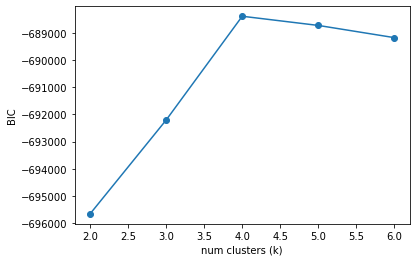

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.plot(range_n_clusters,bic_score,'o-')
ax.set_xlabel("num clusters (k)")
ax.set_ylabel("BIC");